In [1]:
# Freeing CUDA memory: https://stackoverflow.com/questions/55322434/how-to-clear-cuda-memory-in-pytorch 
import torch 
from SPN import SPN 
from matplotlib import pyplot as plt 
from utils import * 
import os 
import matplotlib.pyplot as plt 
from torchinfo import summary 
import numpy as np 
from inference import inference 
from pathlib import Path 
import time
from tqdm import tqdm
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO 
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
import uavFLPO
import GD


In [2]:
def get_speed_grad(Data, beta, vrp_net, n_path_samples, city_dim=2):
    times_L = []
    times_F = []
    grad_norm_error = []

    torch.cuda.empty_cache()
    for data in tqdm(Data):
        s = time.time()
        start_locs, f_base, end_locs = data
        start_locs_np, end_locs_np, f_base_np = torchFLPO_2_numpyFLPO(start_locs, end_locs, f_base, city_dim, scale=1.0)
        f_base_clone = f_base.clone().detach().requires_grad_(True)
        n_facilities = f_base_np.shape[0]

        tic = time.time()
        _, _, G_sampling = GD.sampling_GD_at_beta(
            f_base_clone, 
            start_locs,
            end_locs,
            vrp_net,
            n_path_samples,
            beta,
            stepsize=0.0,
            iters=1
        )
        toc = time.time()
        times_L.append(toc - tic)  
        torch.cuda.empty_cache()

        tic = time.time() 
        for n in range(start_locs_np.shape[0]):
            uav_flpo = uavFLPO.FLPO(
                start_locs_np[n,None],
                end_locs_np[n,None],
                n_facilities,
                scale=1.0,
                disType='sqeuclidean',
                selfHop=False
            )
            D_s, _ = uav_flpo.returnStagewiseCost(f_base_np)
            GD_s, _ = uav_flpo.returnStagewiseGrad(f_base_np)
            _, _, _, _, P_s = uav_flpo.backPropDP(D_s, beta, returnPb=True)
            GV, G_flpo = uav_flpo.backPropDP_grad(GD_s, P_s)
            if n == 0:
                G_flpo_total = np.array([G_flpo])
            else:
                G_flpo_total = np.concatenate((G_flpo_total, np.array([G_flpo])), axis=0)
        G_FLPO = G_flpo_total.mean(axis=0)
        toc = time.time()
        times_F.append(toc-tic)

        grad_norm_error.append(np.linalg.norm(G_FLPO - G_sampling.squeeze().cpu().detach().numpy()))
    
    return times_L, times_F, grad_norm_error

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

print("Running on: " , device) 

num_facilities = np.linspace(50,150,11) # number of facilities 

city_dim = 2
num_distinct_ends=1
Data_1 = []
Data_2 = []
Data_3 = []
Data_4 = []

for i in num_facilities:
    i = int(i)

    num_drones=1
    n_drone_clusters = 3
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_1.append(data)

    num_drones = 10
    n_drone_clusters = 10
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1, num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_2.append(data)

    num_drones = 20
    n_drone_clusters = 20
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_3.append(data)

    num_drones = 50
    n_drone_clusters = 30
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_4.append(data)

Running on:  cuda


In [5]:
num_facilities

array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 150.])

In [6]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path("Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
spn.eval()
print('SPN loaded.')


Model created.
SPN loaded.


# Calculating Gradient Time

In [27]:
beta = 1e1
n_path_samples = 10
times_1_L = []
times_2_L = []
times_3_L = []
times_4_L = []

times_1_F = []
times_2_F = []
times_3_F = []
times_4_F = []

grad_norm_error_1 = []
grad_norm_error_2 = []
grad_norm_error_3 = []
grad_norm_error_4 = []

times_1_L, times_1_F, grad_norm_error_1 = get_speed_grad(Data_1, beta, spn, n_path_samples, city_dim=2)
times_2_L, times_2_F, grad_norm_error_2 = get_speed_grad(Data_2, beta, spn, n_path_samples, city_dim=2)
times_3_L, times_3_F, grad_norm_error_3 = get_speed_grad(Data_3, beta, spn, n_path_samples, city_dim=2)
times_4_L, times_4_F, grad_norm_error_4 = get_speed_grad(Data_4, beta, spn, n_path_samples, city_dim=2)




100%|██████████| 5/5 [00:00<00:00, 10.79it/s]


In [8]:
# # saving the results into a pkl file
# import pickle
# results = {
#     'times_1_L': times_1_L,
#     'times_2_L': times_2_L,
#     'times_3_L': times_3_L,
#     'times_4_L': times_4_L,
#     'times_1_F': times_1_F,
#     'times_2_F': times_2_F,
#     'times_3_F': times_3_F,
#     'times_4_F': times_4_F,
#     'grad_norm_error_1': grad_norm_error_1,
#     'grad_norm_error_2': grad_norm_error_2,
#     'grad_norm_error_3': grad_norm_error_3,
#     'grad_norm_error_4': grad_norm_error_4
# }
# output_file = 'GradSpeedResults.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(results, f)

# Load the Data

In [9]:
# load the results from the pkl file
import pickle
filename = 'GradSpeedResults.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)
times_1_L = results['times_1_L']
times_2_L = results['times_2_L']
times_3_L = results['times_3_L']
times_4_L = results['times_4_L']
times_1_F = results['times_1_F']
times_2_F = results['times_2_F']
times_3_F = results['times_3_F']
times_4_F = results['times_4_F']
grad_norm_error_1 = results['grad_norm_error_1']
grad_norm_error_2 = results['grad_norm_error_2']
grad_norm_error_3 = results['grad_norm_error_3']
grad_norm_error_4 = results['grad_norm_error_4']


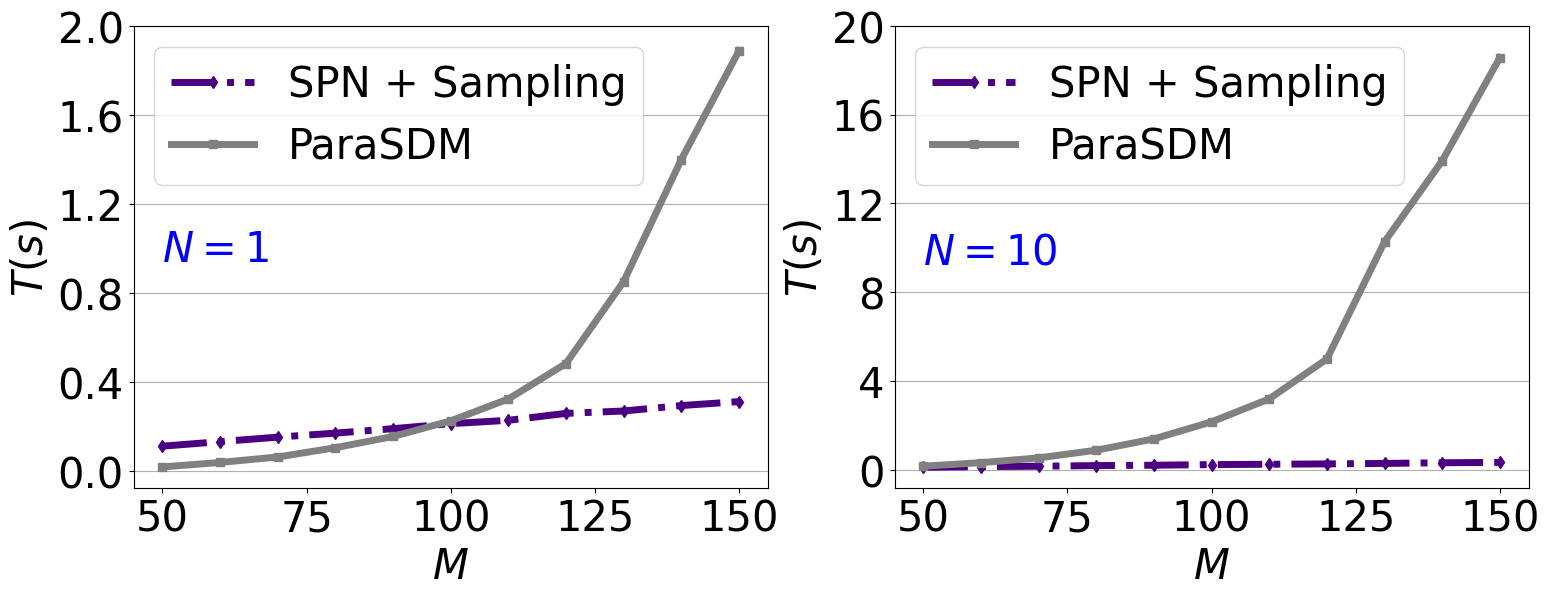

In [16]:
color1 = 'indigo'
color2 = 'gray'
color3 = 'orange'
linestyle1 = '-.'
linestyle2 = '-'
linestyle3 = '--'
fontsize1 = 30
fontsize2 = 30
linewidth1 = 5
num_x_ticks = 5
num_y_ticks = 6
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(num_facilities,times_1_L,linestyle1,marker='d',linewidth=linewidth1,color=color1,label='SPN + Sampling')
plt.plot(num_facilities,times_1_F,linestyle2,marker='s',linewidth=linewidth1,color=color2,label='ParaSDM')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.text(num_facilities[2]-20,times_1_F[-1]*0.5,"$N=1$",fontsize=fontsize1,color='blue',weight='bold')
plt.yticks(np.linspace(0,2,num_y_ticks),fontsize=fontsize1)
plt.xticks(np.linspace(50,150,num_x_ticks),fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)

plt.subplot(1,2,2)
plt.plot(num_facilities,times_2_L,linestyle1,marker='d',linewidth=linewidth1,color=color1,label='SPN + Sampling')
plt.plot(num_facilities,times_2_F,linestyle2,marker='s',linewidth=linewidth1,color=color2,label='ParaSDM')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.text(num_facilities[2]-20,times_2_F[-1]*0.5,"$N=10$",fontsize=fontsize1,color='blue',weight='bold')
plt.yticks(np.linspace(0,20,num_y_ticks),fontsize=fontsize1)
plt.xticks(np.linspace(50,150,num_x_ticks),fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)

# plt.subplot(2,2,3)
# plt.plot(num_facilities,times_3_L,linestyle1,marker='d',linewidth=linewidth1,color=color1,label='SPN + Sampling')
# plt.plot(num_facilities,times_3_F,linestyle2,marker='s',linewidth=linewidth1,color=color2,label='ParaSDM')
# plt.xlabel(rf'$M$', fontsize=fontsize1)
# plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
# plt.text(num_facilities[2],times_3_F[-1]*0.5,"$N=20$",fontsize=fontsize1,color='blue',weight='bold')
# plt.yticks(np.linspace(0,20,num_y_ticks),fontsize=fontsize1)
# plt.xticks(np.linspace(20,100,num_x_ticks),fontsize=fontsize1)
# plt.grid(axis='y',alpha=1)
# plt.legend(fontsize=fontsize1)

# plt.subplot(2,2,4)
# plt.plot(num_facilities,times_4_L,linestyle1,marker='d',linewidth=linewidth1,color=color1,label='SPN + Sampling')
# plt.plot(num_facilities,times_4_F,linestyle2,marker='s',linewidth=linewidth1,color=color2,label='ParaSDM')
# plt.xlabel(rf'$M$', fontsize=fontsize1)
# plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
# plt.text(num_facilities[2],times_4_F[-1]*0.5,"$N=50$",fontsize=fontsize1,color='blue',weight='bold')
# plt.yticks(np.linspace(0,50,num_y_ticks),fontsize=fontsize1)
# plt.xticks(np.linspace(20,100,num_x_ticks),fontsize=fontsize1)
# plt.grid(axis='y',alpha=1)
# plt.legend(fontsize=fontsize1)

# plt.figure(figsize=(16,3))
# plt.plot(num_facilities,grad_norm_error_1,linestyle1,marker='v',color=color1,label='grad_norm_error')
# plt.xlabel('Num F')
# # plt.ylabel('')
# plt.title('N_drones = 1')
# # plt.yticks(np.linspace(0,35,15))
# plt.grid(axis='y',alpha=1)
# plt.legend()
plt.savefig("SpeedTestGrad.png", bbox_inches='tight', dpi=300)
# plt.show()